<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Keypoint Detection using IceVision

## Introduction

This tutorial walk you through the different steps of training the biwi dataset. the IceVision Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai](https://github.com/fastai/fastai) library, and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) libraries.

For more information about how the biwi dataset as well as its corresponding parser check out the [biwi folder](https://github.com/airctic/icedata/tree/master/icedata/datasets/biwi) in icedata.

## Installing IceVision and IceData

Install from pypi...

In [2]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 master

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

## Imports

In [3]:
from icevision.all import *

### Alternative option of importing icevision

In some environments wildcard imports are not allowed (eg: Kubeflow Pipelines & distributed environment that rely on pickling). 

In that case you can call `import icevision.all as iv`  instead of `from icevision.all import *`

In that case you should reference icevision objects with the `iv.` prefix, so for instance one would do `iv.Dataset` instead of the regular approach of just doing `Dataset`, same for any other icevision object (eg: `iv.tfms.A.Adapter` instead of `tfms.A.Adapter` etc).

## Model
To create a model, we need to:

* Choose one of the **models** supported by IceVision
* Choose one of the **backbones** corresponding to a chosen model
* Determine the **number of the object classes**: This will be done after parsing a dataset. Check out the Parsing Section 

## Choose a model and backbone

**TorchVision**

In [4]:
model_type = models.torchvision.keypoint_rcnn
backbone = model_type.backbones.resnet34_fpn()

## Datasets : Biwi
Biwi dataset is tiny dataset that contains 200 images of 1 class `Nose`.

We will use `icedata` to download the dataset and get it with pre-defined transforms for training and validation.

> Note: If you want a more challenging dataset take a look at [OCHuman](https://github.com/airctic/icedata/tree/master/icedata/datasets/ochuman).

In [5]:
# Loading Data
data_dir = icedata.biwi.load_data()

In [ ]:
train_ds, valid_ds = icedata.biwi.dataset(data_dir)

### Displaying the same image with different transforms

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

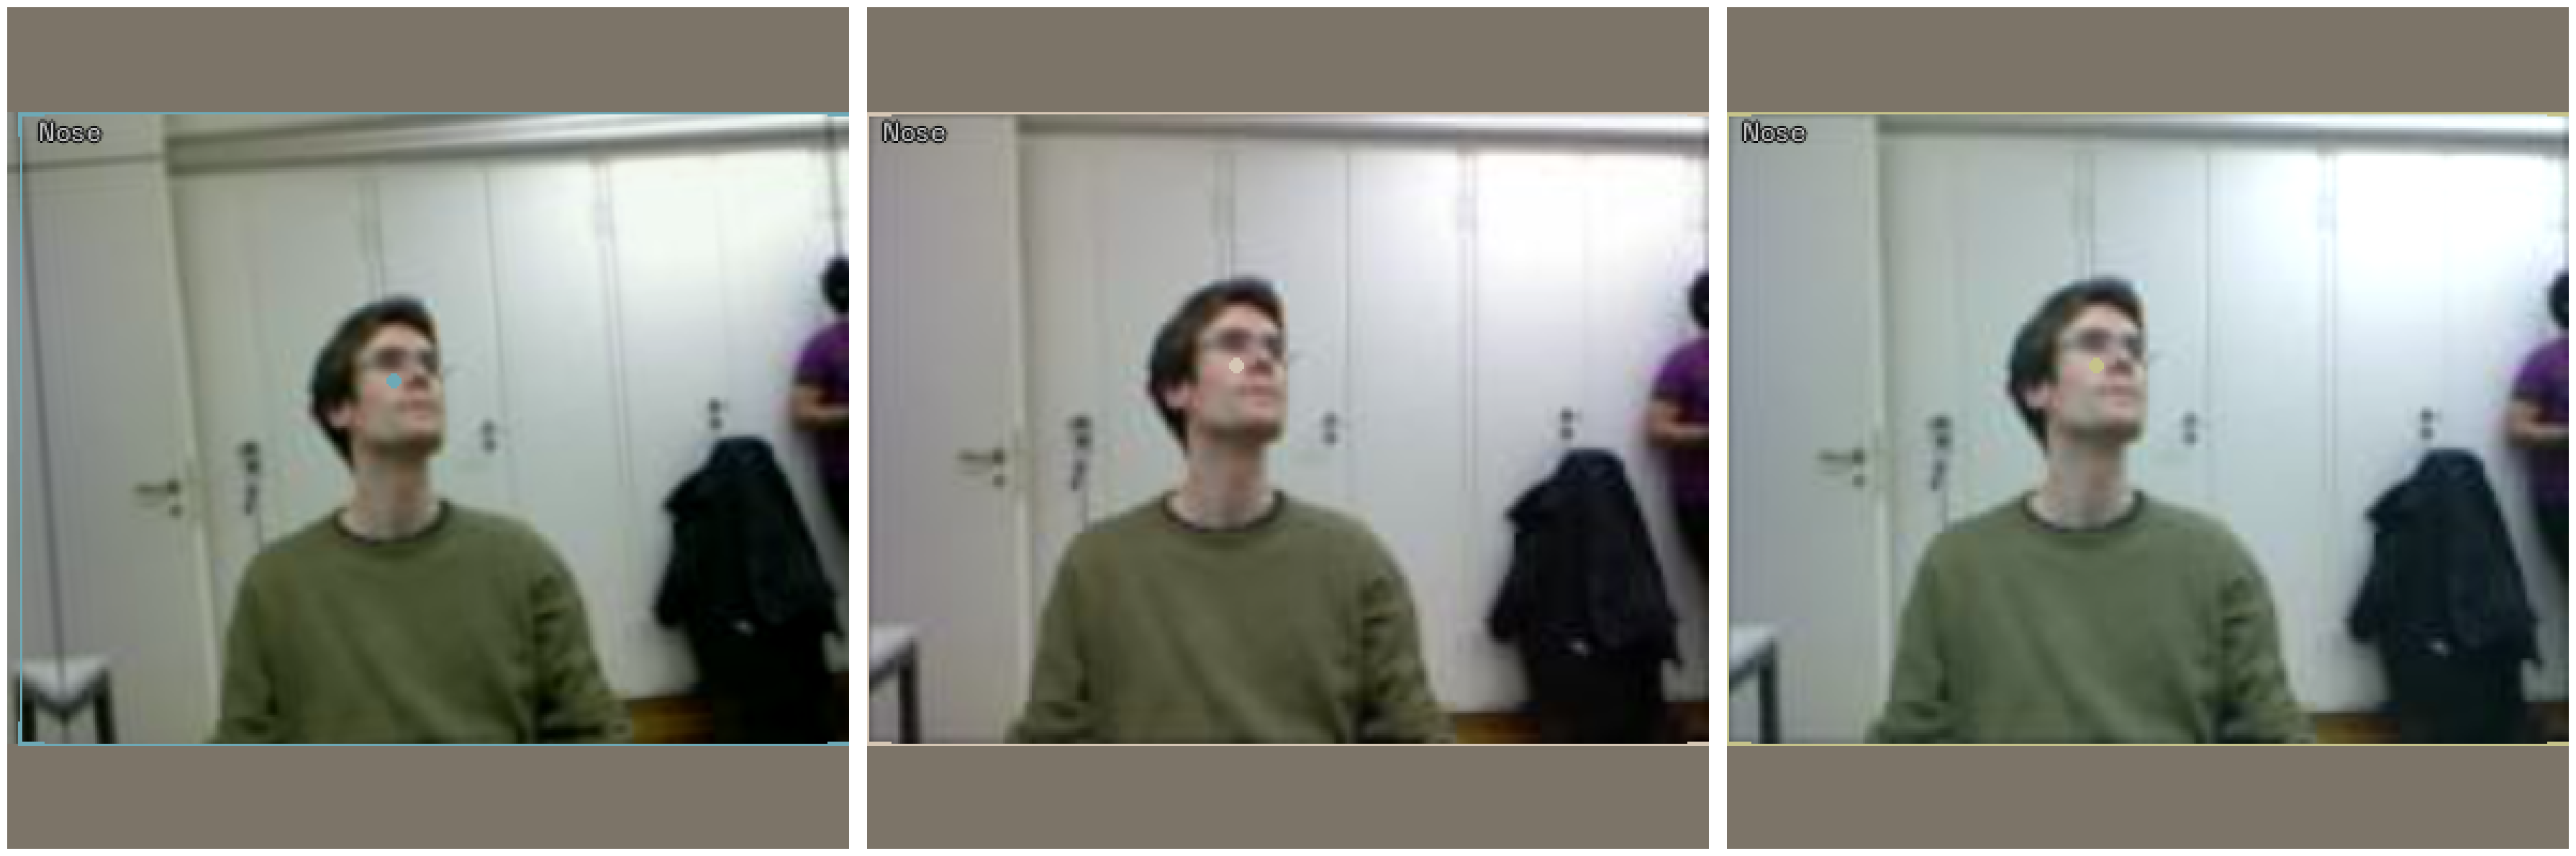

In [7]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## DataLoader

In [8]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

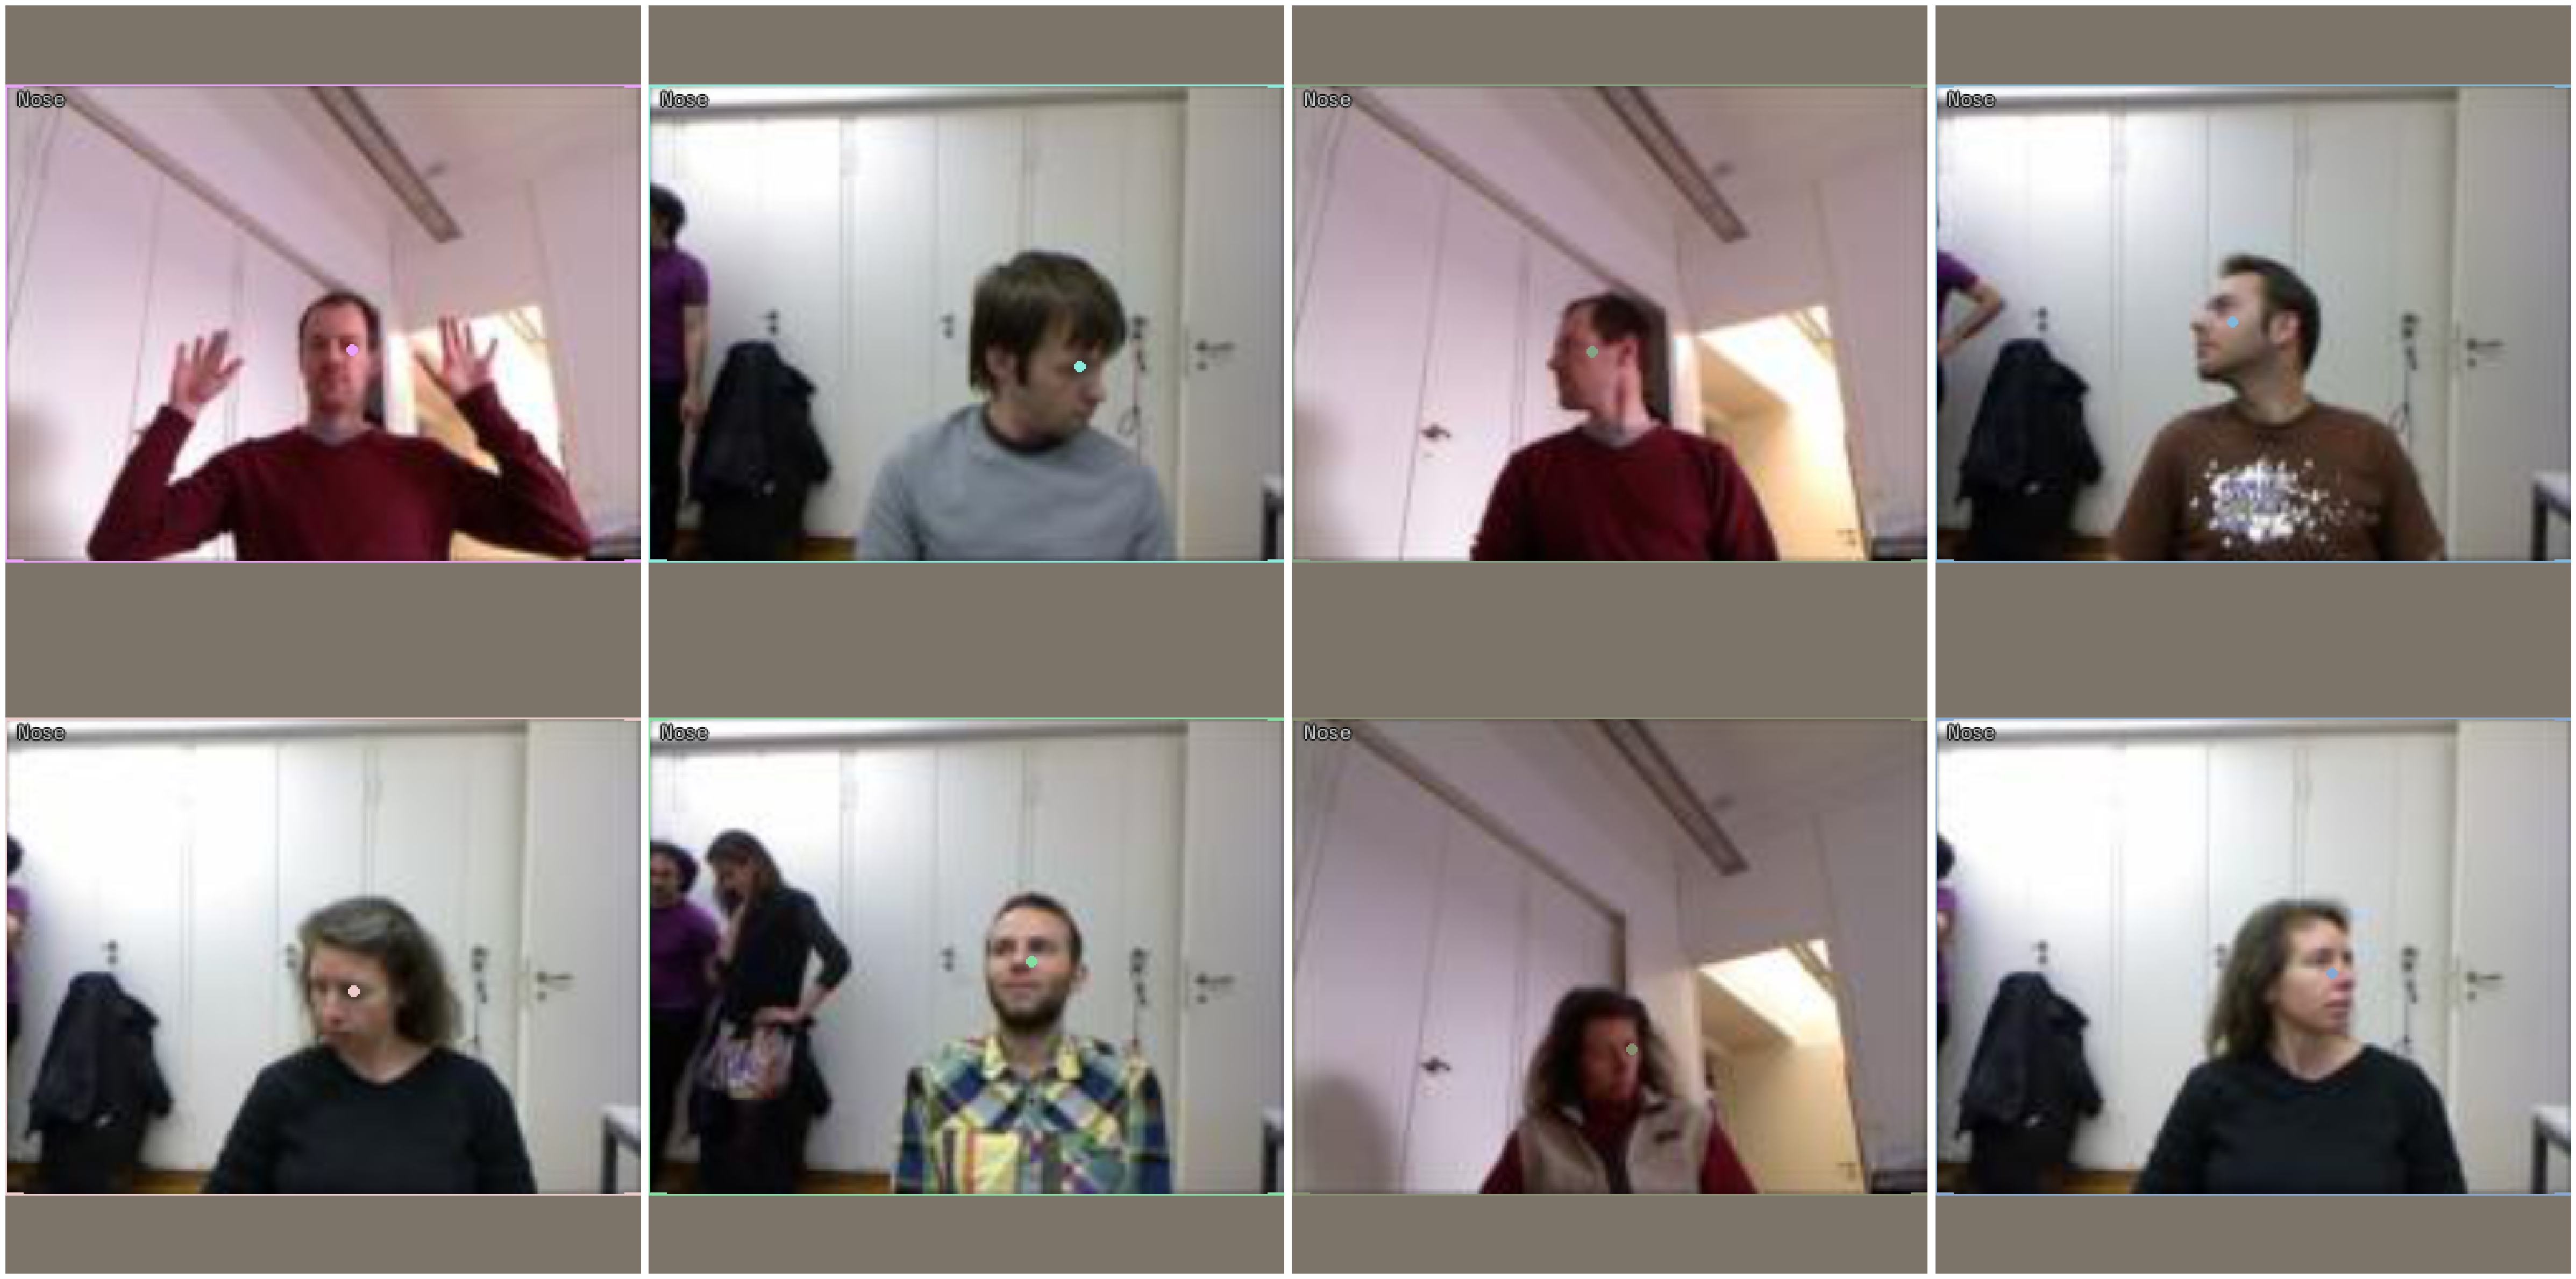

In [9]:
model_type.show_batch(first(valid_dl), ncols=4)

## Model

Now that we determined the number of classes (`num_classes`) and number of keypoints (`num_keypoints`), we can create our `model` object.

In [10]:
# TODO: Better flow for train_ds
model = model_type.model(backbone=backbone, num_keypoints=1, num_classes=icedata.biwi.NUM_CLASSES) 

## Metrics

Metrics for keypoint are a work in progress

In [11]:
# metrics = [COCOMetric(metric_type=COCOMetricType.keypoint)]

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai

In [11]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model)

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=0.00010964782268274575)

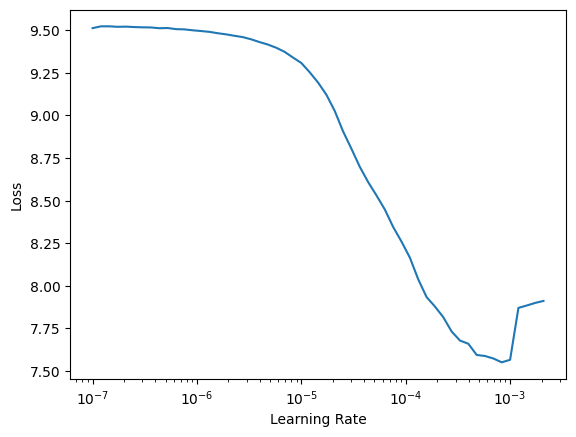

In [12]:
learn.lr_find()

In [13]:
learn.fine_tune(10, 3e-5, freeze_epochs=1)

epoch,train_loss,valid_loss,time
0,8.645806,7.013292,00:28


epoch,train_loss,valid_loss,time
0,6.684147,6.487582,00:26
1,6.277197,5.731036,00:26
2,5.836541,5.114465,00:26
3,5.408250,4.583161,00:20
4,4.996461,4.225419,00:23
5,4.657006,3.987719,00:21
6,4.335581,3.832931,00:20
7,4.114164,3.862228,00:20
8,3.902603,3.697594,00:20
9,3.768973,3.694008,00:21


### Training using Lightning

In [14]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=3e-5)
    
light_model = LightModel(model)

In [16]:
trainer = pl.Trainer(max_epochs=2, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Show Results

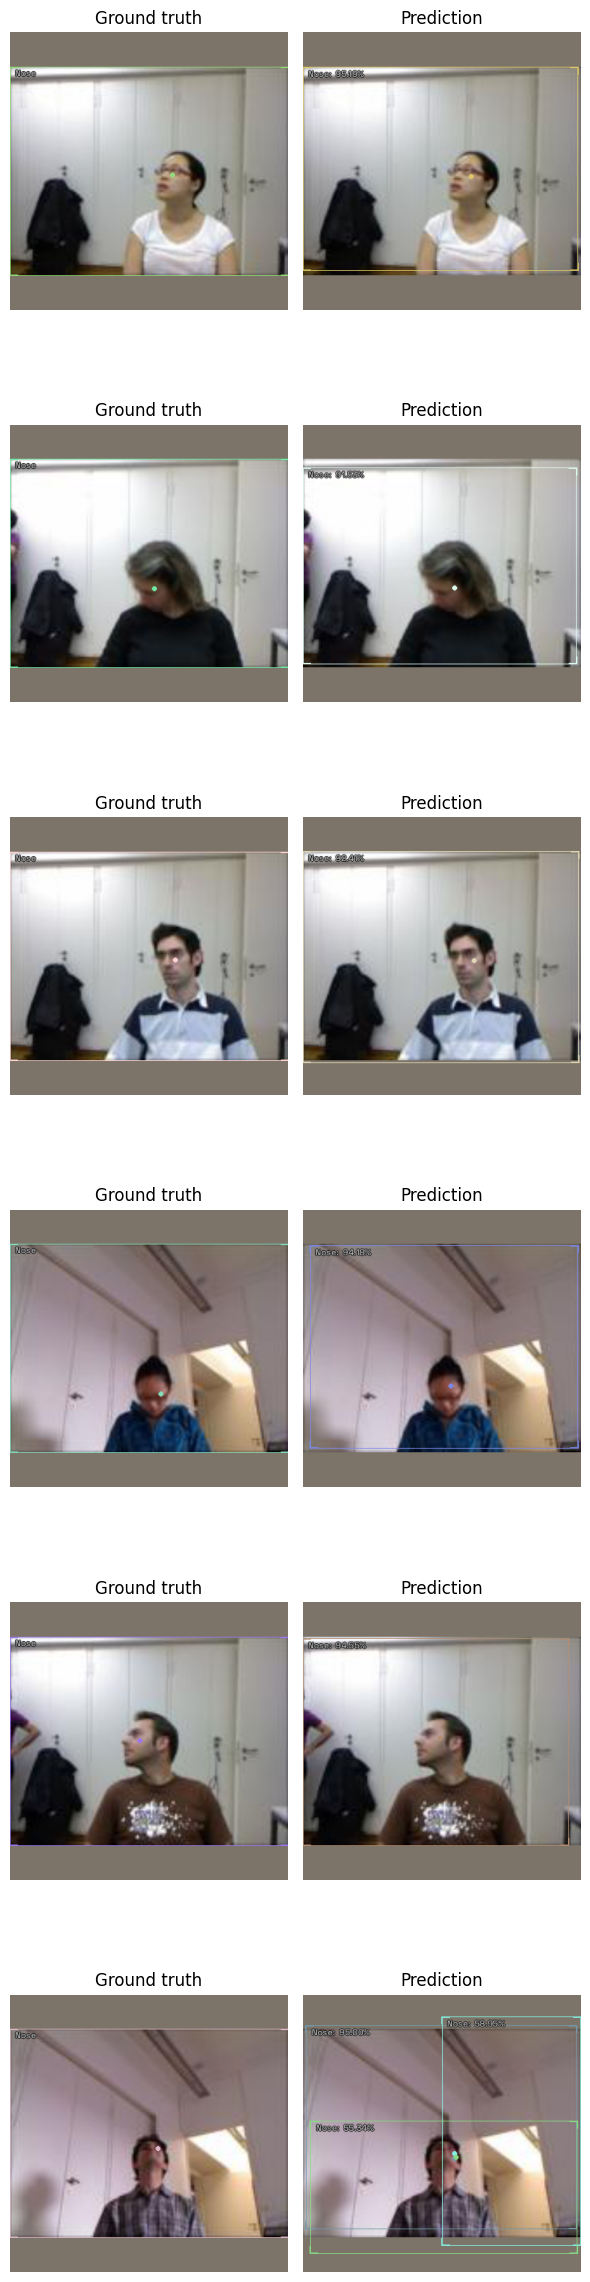

In [14]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

## Inference

### Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batches at the time: This option is more memory efficient. 


> NOTE: For a more detailed look at inference check out the [inference tutorial](https://airctic.com/dev/inference/)

In [17]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

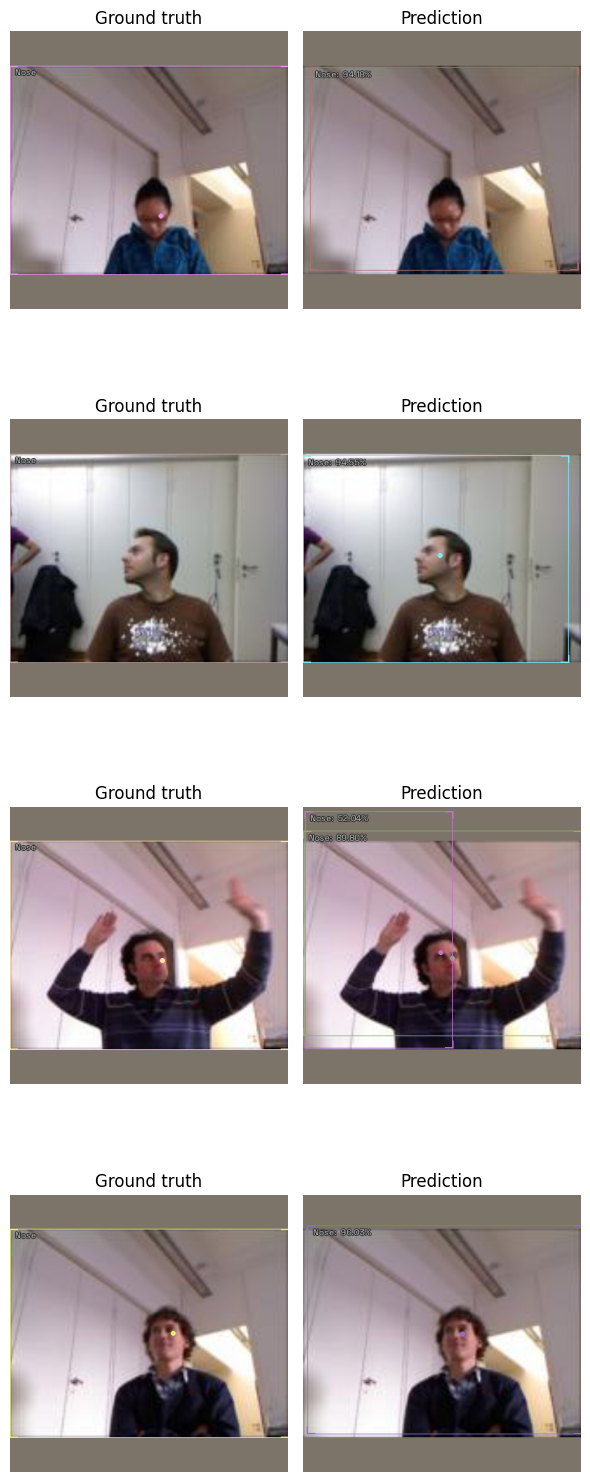

In [16]:
show_preds(preds=preds[:4])

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).